# <center>  WASTE CLASSIFICATION - A COMPARATIVE ANALYSIS OF CNN AND HYBRID MODELS (CNN + RNN(LSTM)) 


> Terms
------------------
- CNN  - Convolutional Neural Network
- RNN  - Recurrent Neural Network
- LSTM - Long-Short Term Memory

In [1]:
#import libraries
import cv2                        #image processing
import os                         #operating system settings
import sys                        #system settings
import numpy as np               #data manipulation
import matplotlib.pyplot as plt  #plotting
import pandas as pd              #data manipulation
from sklearn.model_selection import train_test_split, KFold # for splitting data
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import augment
import pickle
import warnings
warnings.filterwarnings("ignore")  #stop warnings from printing

## Data Exploration

In [2]:
rootdir= "C:/Users/swint/Documents/uol masters/UoL Masters/data/RealWaste"

labels, filepaths = augment.read_files(rootdir)

data = pd.DataFrame({'Label': labels, 'Original_Image': filepaths})
print("There are {} images in the data belonging to {} classes".format(data.shape[0], len(data["Label"].unique())))
print("-------------------------------------------")
print("LIST OF CLASSES")
print("-------------------------------------------")
print(data["Label"].unique())
print("-------------------------------------------")
print("DATA PREVIEW")
print("-------------------------------------------")
data.head()

There are 4752 images in the data belonging to 9 classes
-------------------------------------------
LIST OF CLASSES
-------------------------------------------
['Cardboard' 'Food Organics' 'Glass' 'Metal' 'Miscellaneous Trash' 'Paper'
 'Plastic' 'Textile Trash' 'Vegetation']
-------------------------------------------
DATA PREVIEW
-------------------------------------------


,Label,Original_Image
0,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...
1,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...
2,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...
3,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...
4,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...


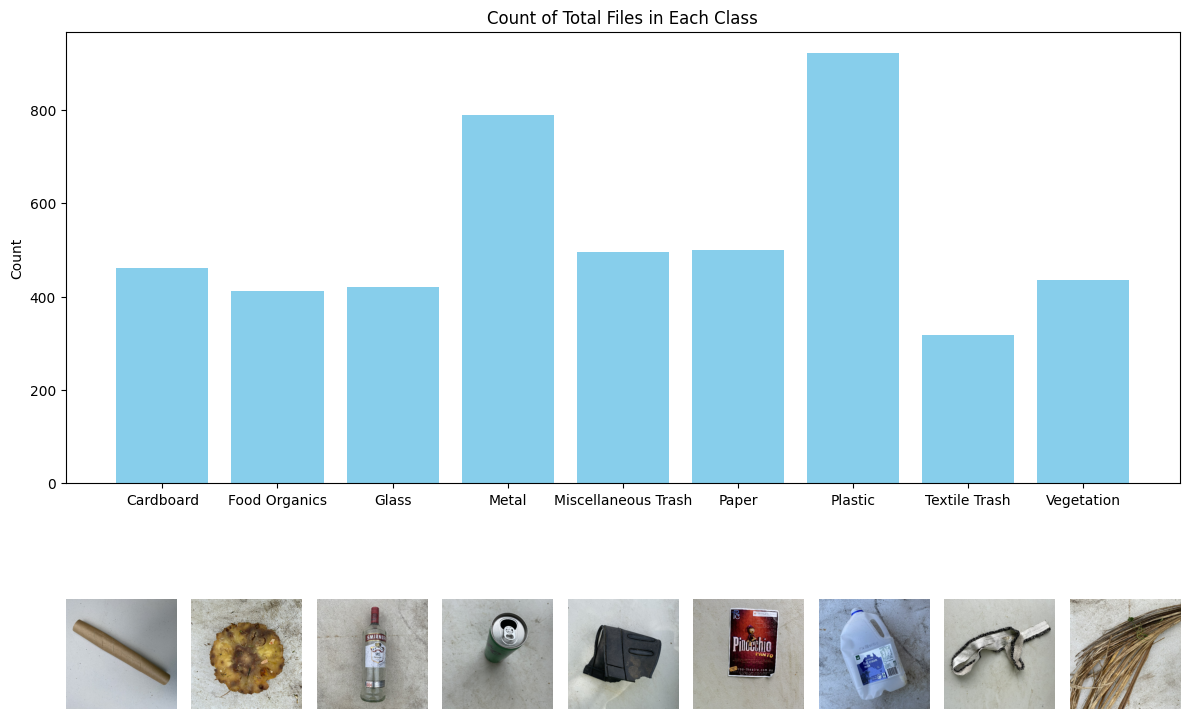

In [3]:
# COUNT OF TOTAL FILES IN EACH CLASS
label, count=np.unique(labels, return_counts=True)

augment.plot_bar(data,label,count)

## Data Splitting and Augmentation

In [4]:
# Split the data into 70% training, 20% validation, and 10% test sets
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=(1/3), stratify=temp_data['Label'], random_state=42)

generator, train_images, val_images, test_images= augment.create_gen(train_data,val_data,test_data)

Found 3326 validated image filenames belonging to 9 classes.
Found 950 validated image filenames belonging to 9 classes.
Found 476 validated image filenames belonging to 9 classes.


In [5]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Cardboard',
 1: 'Food Organics',
 2: 'Glass',
 3: 'Metal',
 4: 'Miscellaneous Trash',
 5: 'Paper',
 6: 'Plastic',
 7: 'Textile Trash',
 8: 'Vegetation'}

In [6]:
train_data.head()

,Label,Original_Image
2892,Paper,C:/Users/swint/Documents/uol masters/UoL Maste...
3354,Plastic,C:/Users/swint/Documents/uol masters/UoL Maste...
809,Food Organics,C:/Users/swint/Documents/uol masters/UoL Maste...
2014,Metal,C:/Users/swint/Documents/uol masters/UoL Maste...
278,Cardboard,C:/Users/swint/Documents/uol masters/UoL Maste...


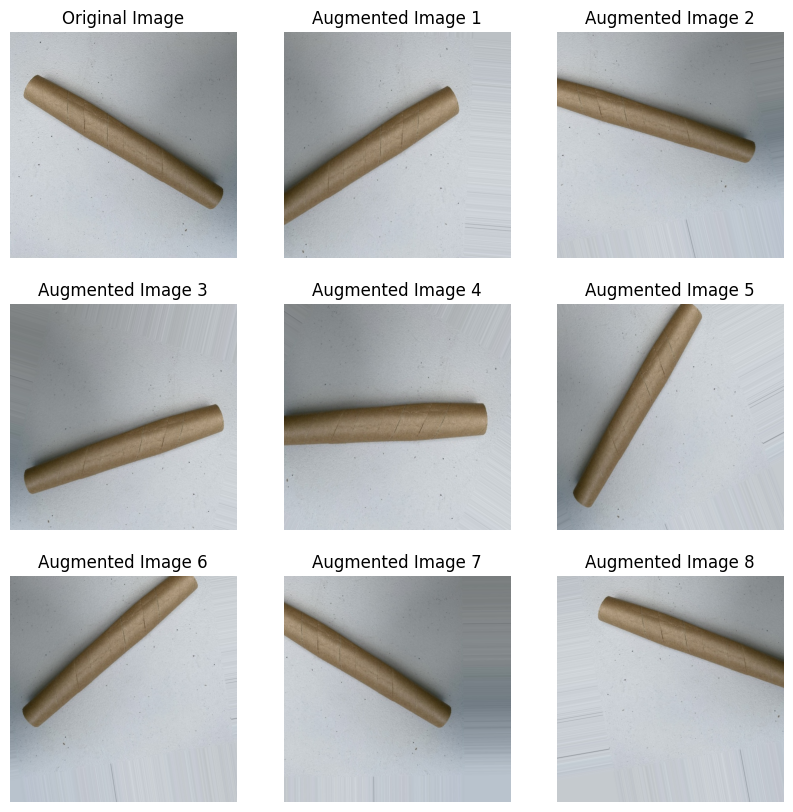

In [7]:
img_path=data['Original_Image'].iloc[0]
img=cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
augment.display_augmented_images(img, generator, num_examples=9) # display image and its augmented forms

In [8]:
# Reset all state generated by Keras.
tf.keras.backend.clear_session()

## Modeling

In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Standalone CNN + EfficientNetV2B0

In [10]:
inputs = pretrained_model.input

model = tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
model = tf.keras.layers.Dense(180, activation='relu', kernel_regularizer=l2(0.001))(model)
outputs = tf.keras.layers.Dense(9, activation='softmax')(model)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 56, 56, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 56, 56, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 56, 56, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 56, 56, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 56, 56, 128)       │          36,86

 Total params: 6,052,611 (23.09 MB)

 Trainable params: 133,299 (520.70 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [12]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetV2B0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [13]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4615 - loss: 1.7851
Epoch 1: val_accuracy improved from -inf to 0.70211, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.4629 - loss: 1.7815 - val_accuracy: 0.7021 - val_loss: 1.1218 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7789 - loss: 0.9089
Epoch 2: val_accuracy improved from 0.70211 to 0.75895, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7789 - loss: 0.9085 - val_accuracy: 0.7589 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8182 - loss: 0.7759
Epoch 3: val_accuracy improved from 0.75895 to 0.77263, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8182 - loss: 0.7757 - val_accuracy: 0.7726 - val_loss: 0.9274 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━

In [20]:
# Load the model from the file
#model = load_model("efficientnetV2B0.keras")
model = load_model("cnnModel.keras")
# evaluate on validation set
results = model.evaluate(val_images, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.67663
Validation Accuracy: 85.05%


In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
The first 5 predictions: ['Plastic', 'Miscellaneous Trash', 'Plastic', 'Plastic', 'Textile Trash']


In [18]:
# generate classification report
y_test = list(test_data.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

          Cardboard       0.88      0.91      0.89        46
      Food Organics       0.92      0.88      0.90        41
              Glass       0.84      0.90      0.87        42
              Metal       0.76      0.94      0.84        79
Miscellaneous Trash       0.88      0.56      0.68        50
              Paper       1.00      0.80      0.89        50
            Plastic       0.82      0.87      0.85        92
      Textile Trash       0.88      0.94      0.91        32
         Vegetation       0.95      0.93      0.94        44

           accuracy                           0.86       476
          macro avg       0.88      0.86      0.86       476
       weighted avg       0.87      0.86      0.86       476



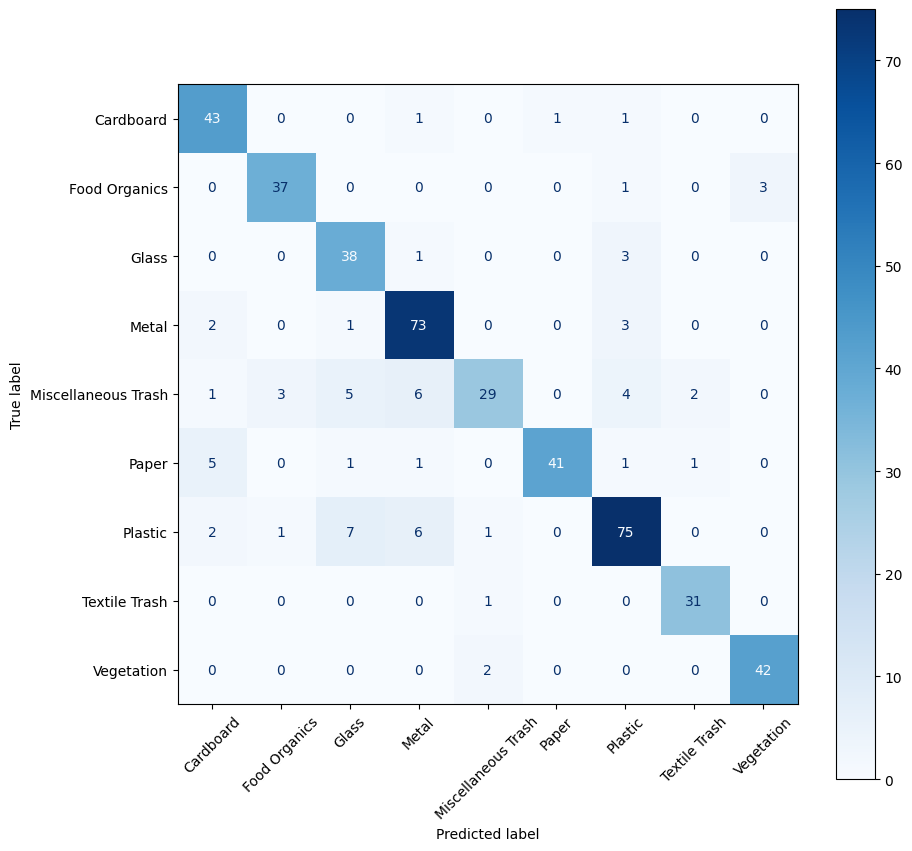

Test Accuracy: 0.86


In [21]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_images.class_indices.keys())

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, pred)
print(f"Test Accuracy: {accuracy:.2f}")

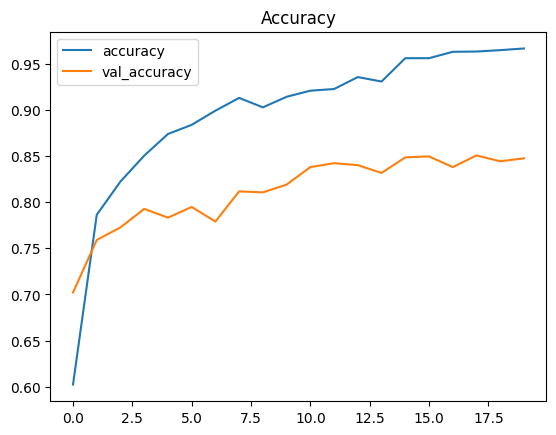

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

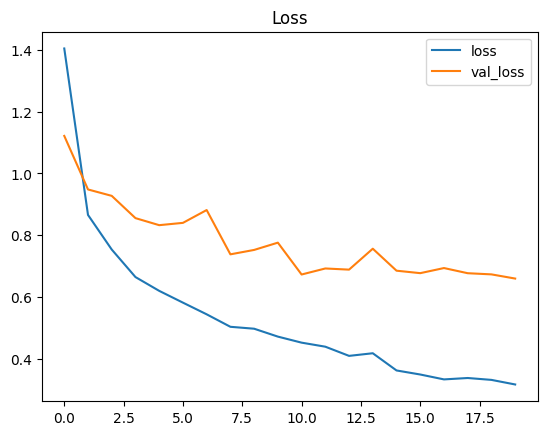

In [21]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
#save model
model.save("cnnModel.keras")

### Hybrid EfficientNetV2B0 + LSTM

In [9]:
from tensorflow.keras.layers import LSTM, Reshape

# Load the pretrained model
pretrained_model2 = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model2.trainable = False

inputs = pretrained_model2.input

# Get the output from the pretrained model
x = pretrained_model2.output

# Reshape the output to add a time dimension
x = Reshape((1, -1))(x)  # Reshape to (batch_size, time_steps, features)

# Add LSTM layers
x = LSTM(800, return_sequences=True)(x)
x = LSTM(160)(x)

# Add dense layers
x = tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.Dense(180, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model_l = tf.keras.Model(inputs=inputs, outputs=outputs)

model_l.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model_l.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,216 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_bn             │ (None, 56, 56, 64)        │             256 │ block2a_expand_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_activation     │ (None, 56, 56, 64)        │               0 │ block2a_expand_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_conv (Conv2D) │ (None, 56, 56, 32)        │           2,048 │ block2a_expand_activation… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_project_bn            │ (None, 56, 56, 32)        │             128 │ block2a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2b_expand_conv (Conv2D)  │ (None, 56, 56, 128)       │          36,86

 Total params: 13,226,051 (50.45 MB)

 Trainable params: 7,306,739 (27.87 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [10]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("efficientnetV2B0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [11]:
history_l = model_l.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4376 - loss: 1.7302
Epoch 1: val_accuracy improved from -inf to 0.69053, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.4391 - loss: 1.7263 - val_accuracy: 0.6905 - val_loss: 1.0595 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7820 - loss: 0.7765
Epoch 2: val_accuracy improved from 0.69053 to 0.74632, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7820 - loss: 0.7764 - val_accuracy: 0.7463 - val_loss: 0.9140 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8325 - loss: 0.6191
Epoch 3: val_accuracy improved from 0.74632 to 0.77368, saving model to efficientnetV2B0.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.8324 - loss: 0.6193 - val_accuracy: 0.7737 - val_loss: 0.7948 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━

In [12]:
# Load the model from the file
model_l = load_model("efficientnetV2B0.keras")
results = model_l.evaluate(val_images, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.57560
Validation Accuracy: 85.58%


In [13]:
# Predict the label of the test_images
pred = model_l.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
The first 5 predictions: ['Plastic', 'Cardboard', 'Plastic', 'Plastic', 'Textile Trash']


In [14]:
y_test = list(test_data.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

          Cardboard       0.81      0.93      0.87        46
      Food Organics       0.90      0.90      0.90        41
              Glass       0.73      0.90      0.81        42
              Metal       0.83      0.92      0.87        79
Miscellaneous Trash       0.88      0.58      0.70        50
              Paper       0.98      0.82      0.89        50
            Plastic       0.85      0.82      0.83        92
      Textile Trash       0.91      0.97      0.94        32
         Vegetation       0.93      0.95      0.94        44

           accuracy                           0.86       476
          macro avg       0.87      0.87      0.86       476
       weighted avg       0.87      0.86      0.86       476



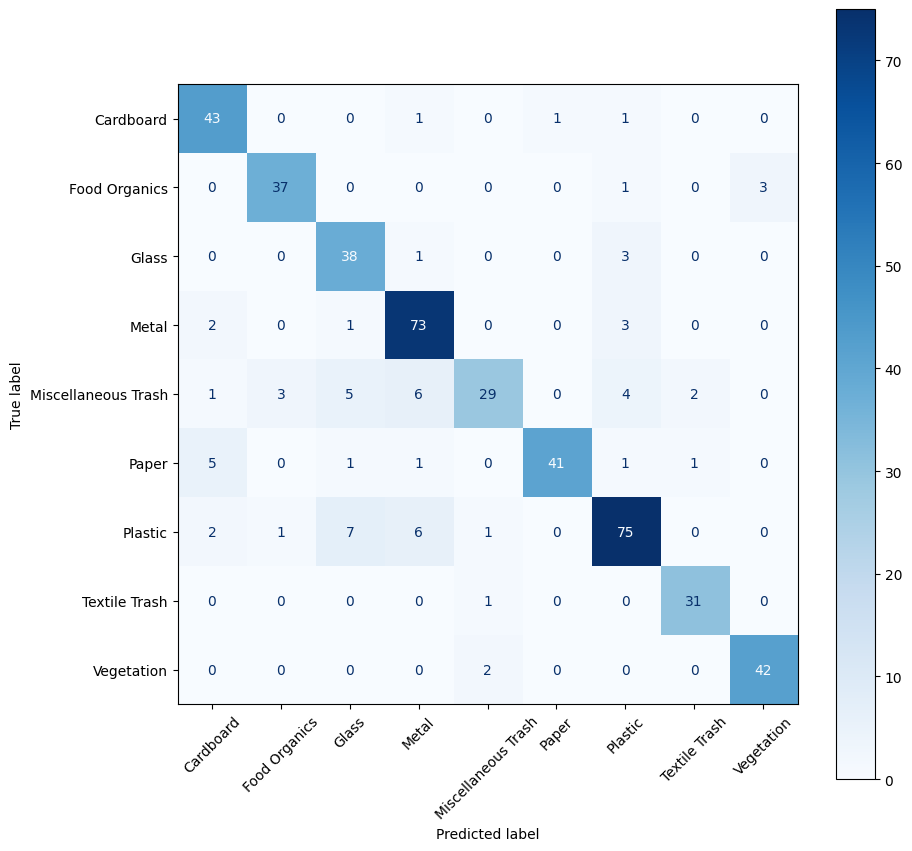

Test Accuracy: 0.86


In [15]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_images.class_indices.keys())

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, ax=ax)
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, pred)
print(f"Test Accuracy: {accuracy:.2f}")

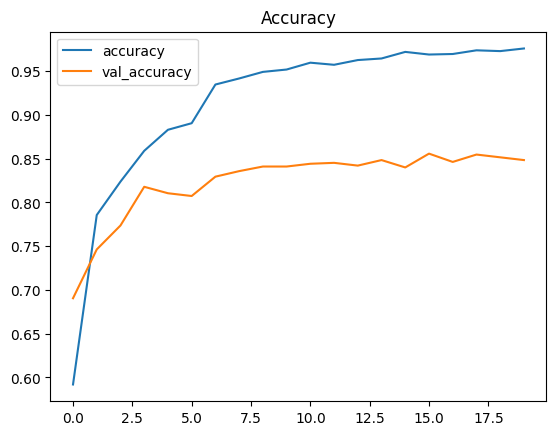

In [17]:
pd.DataFrame(history_l.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

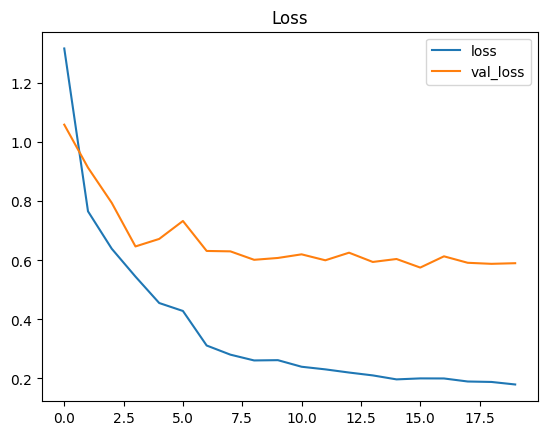

In [18]:
pd.DataFrame(history_l.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
#save model
model_l.save("HYBModel.keras")

In [1]:
import os
import psutil

# CPU information
cpu_info = os.cpu_count()
print(f"Number of CPUs: {cpu_info}")

# Memory information
mem = psutil.virtual_memory()
print(f"Total Memory: {mem.total / (1024 ** 3):.2f} GB")

# Disk information
disk = psutil.disk_usage('/')
print(f"Total Disk Space: {disk.total / (1024 ** 3):.2f} GB")

Number of CPUs: 4
Total Memory: 3.88 GB
Total Disk Space: 237.87 GB
